In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle/"


In [ ]:
! kaggle datasets download -d aftaab/mscoco

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip mscoco.zip

Streaming output truncated to the last 5000 lines.
  inflating: mscoco_resized/train2014/COCO_train2014_000000380928.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380931.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380935.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380938.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380949.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380957.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380959.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380981.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380983.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380989.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000380998.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000381000.jpg  
  inflating: mscoco_resized/train2014/COCO_train2014_000000381003.jpg  
  inflating: 

In [ ]:
 cp /content/drive/MyDrive/fyp/img_array.pickle /content

In [ ]:
 cp /content/img_array_4k_.pickle /content/drive/MyDrive/fyp

cp: cannot stat '/content/img_array_6k.pickle': No such file or directory


In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from multiprocessing import Pool
import pickle
import glob
import shutil
import os
from tqdm import tqdm

In [ ]:
mkdir subset2

In [ ]:
src_dir = "/content/mscoco/mscoco_resized/train2014"
dst_dir = "/content/subset2"

i=0
for jpgfile in tqdm(sorted(glob.iglob(os.path.join(src_dir, "*.jpg")))):
    if i > 6000:
      break
    i+=1
    shutil.copy(jpgfile, dst_dir)

  7%|▋         | 6001/82783 [00:01<00:13, 5680.37it/s]


In [ ]:
with open('/content/drive/MyDrive/fyp/img_array_2k_256.pickle','wb') as f:
  pickle.dump(img_hi, f)
  print(len(img_hi))

In [ ]:
with open('/content/drive/MyDrive/fyp/img_hi_np.pickle','rb') as f:
  img_hi = pickle.load(f)

# with open('/content/drive/MyDrive/fyp/img_hi_np.pickle','rb') as f:
#   img_low = pickle.load(f)

In [ ]:
img_hi = img_hi[:1000]
# img_low = img_low[:1700]

In [ ]:
face_images = sorted(glob.glob('/content/subset/*.jpg'))
print(len(face_images))

def read(path):
  img = load_img(path, target_size=(256,256,3))
  img = img_to_array(img)
  img = img/255.
  return img
p= Pool(10)
img_hi = p.map(read, face_images)


In [ ]:
face_images = sorted(glob.glob('/content/subset/*.jpg'))
print(len(face_images))

def read(path):
  img = load_img(path, target_size=(128,128,3))
  img = img_to_array(img)
  img = img/255.
  return img
p= Pool(10)
img_low = p.map(read, face_images)


In [ ]:
img_hi = np.array(img_hi)
# img_low = np.array(img_low)
# train_x, val_x = train_test_split(img_low,random_state = 32, test_size=0.2)
train_vx, val_vx = train_test_split(img_hi,random_state = 32, test_size=0.2)

In [ ]:
def pixalate_image(image, scale_percent = 50):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
  return low_res_image

In [ ]:
# train_x = []
# for i in range(train_vx.shape[0]):
#   temp = pixalate_image(train_vx[i,:,:,:])
#   train_x.append(temp)
# train_x = np.array(train_x)
val_x = []
for i in range(val_vx.shape[0]):
  temp = pixalate_image(val_vx[i,:,:,:])
  val_x.append(temp)
val_x = np.array(val_x)

In [ ]:
temp = pixalate_image(train_x[i,:,:,:])
print(temp.shape)

(256, 256, 3)


In [ ]:
Input_img = Input(shape=(256,256, 3))

#encoding architecture
x1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(x1)
x5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(x5)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(encoded)
x9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(x8)
x10 = Add()([x5, x9])
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(x10)
x14 = Add()([x2, x13])
x14 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-11))(x14)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-11))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  73792       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('enhancer.h5', save_best_only = True)

In [ ]:
history = autoencoder.fit(train_x,train_vx,
            epochs=50,
            validation_data=(val_x, val_vx),
            callbacks=[early_stopper, model_checkpoint], batch_size=5)

Epoch 1/50
160/160 [==============================] - 45s 162ms/step - loss: 0.0117 - accuracy: 0.7253 - val_loss: 0.0029 - val_accuracy: 0.8440
Epoch 2/50
160/160 [==============================] - 26s 162ms/step - loss: 0.0029 - accuracy: 0.8471 - val_loss: 0.0025 - val_accuracy: 0.8701
Epoch 3/50
160/160 [==============================] - 27s 166ms/step - loss: 0.0027 - accuracy: 0.8712 - val_loss: 0.0023 - val_accuracy: 0.8947
Epoch 4/50
160/160 [==============================] - 26s 161ms/step - loss: 0.0024 - accuracy: 0.8851 - val_loss: 0.0022 - val_accuracy: 0.8755
Epoch 5/50
160/160 [==============================] - 27s 166ms/step - loss: 0.0022 - accuracy: 0.8941 - val_loss: 0.0020 - val_accuracy: 0.9114
Epoch 6/50
160/160 [==============================] - 26s 160ms/step - loss: 0.0024 - accuracy: 0.8711 - val_loss: 0.0021 - val_accuracy: 0.8649
Epoch 7/50
160/160 [==============================] - 26s 160ms/step - loss: 0.0021 - accuracy: 0.8919 - val_loss: 0.0019 - val_ac

In [ ]:
# autoencoder = load_model('/content/enhance.h5')
pred = autoencoder.predict(val_x)

7/7 [==============================] - 2s 262ms/step


In [ ]:
n = 10
j=0
plt.figure(figsize= (20,20))
for i in range(n):
  j +=1
  ax = plt.subplot(4, 4 , j)
  plt.imshow(val_x[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  j +=1
  ax = plt.subplot(4, 4, j)
  plt.imshow(pred[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  print()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cp /content/upscaler_6k.h5 /content/drive/MyDrive/personal/

In [ ]:
img = load_img("/content/(7).jpg", target_size=(128,128,3))
img = img_to_array(img)
img = img/255.

p= Pool(10)
img_ = p.map(img, )

In [ ]:
results = autoencoder.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)

38/38 [==============================] - 3s 62ms/step - loss: 0.0060 - accuracy: 0.8979
val_loss, val_accuracy [0.006007855292409658, 0.8979158997535706]


In [ ]:
cp /content/drive/MyDrive/personal/scratch_rem2.h5  /content/

1/1 [==============================] - 2s 2s/step


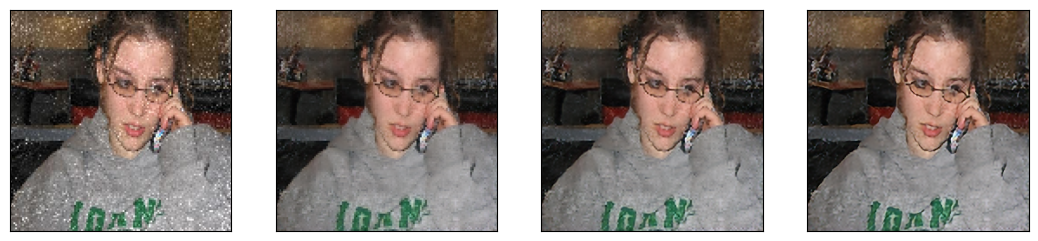

In [ ]:
face_images = sorted(glob.glob('/content/*.jpg'))

def read(path):
  img = load_img(path, target_size=(128,128,3))
  img = img_to_array(img)
  img = img/255.
  # progress.update(1)
  return img
p = Pool(10)
img_array = p.map(read, face_images)

img_ =np.array(img_array)

y = load_model("enhance.h5")
z = load_model("upscale_div2k.h5")
x = load_model("scratch_rem.h5")


a = x.predict(img_)
b = z.predict(a)
b =
c = y.predict(b)

j=0
i=3
plt.figure(figsize= (20,20))
j +=1
ax = plt.subplot(4, 6, j)
plt.imshow(img_[i])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
j +=1
ax = plt.subplot(4, 6 , j)
plt.imshow(a[i])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
j +=1
ax = plt.subplot(4, 6, j)
plt.imshow(b[i])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
j +=1
ax = plt.subplot(4, 6, j)
plt.imshow(c[i])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from skimage import metrics

mse_skimg = 0
psnr_skimg = 0
rmse_skimg = 0

for i in range(len(val_vx)):
    mse_skimg = mse_skimg + metrics.mean_squared_error(val_vx[i], pred[i])
    psnr_skimg = psnr_skimg + metrics.peak_signal_noise_ratio(val_vx[i], pred[i], data_range=len(val_vx))
    rmse_skimg = rmse_skimg + metrics.normalized_root_mse(val_vx[i], pred[i])

mse_avg = mse_skimg/len(pred)
psnr_avg = psnr_skimg/len(pred)
rmse_avg = rmse_skimg/len(pred)

print("MSE: Average = ", mse_avg)
print("PSNR: Average = ", psnr_avg)
print("RMSE: Average = ", rmse_avg)

MSE: Average =  0.0017364387758658781
PSNR: Average =  75.52284163645123
RMSE: Average =  0.07588492594058731
